# Project 2: Predictability of financial data


Pletinka Andrii <br>
Yamkova Sofia <br>
Zarichanska Yelizaveta <br>
Yevchenko Dimitriy


In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings('ignore')

The data was extracted from MATLAB file and loaded in excel, then exported as csv.

In [13]:
exrets_path = 'https://raw.githubusercontent.com/andriipletinka/Bond-Return-Predictability/main/ExRets.csv'
fred_data_path = 'https://raw.githubusercontent.com/andriipletinka/Bond-Return-Predictability/main/Fred_DATA.csv'
fwdrate_path = 'https://raw.githubusercontent.com/andriipletinka/Bond-Return-Predictability/main/fwdrate.csv'

In [14]:
exrets = pd.read_csv(exrets_path, sep=';')
fred_data = pd.read_csv(fred_data_path, sep=';')
fwdrate = pd.read_csv(fwdrate_path, sep=';')

### Header representation of the files

In [15]:
exrets.head()

,DATE,1YEAR,2YEAR,5YEAR,10YEAR
0,31.01.1964,0.182672,0.434549,0.416700,0.532450
1,29.02.1964,-0.147380,0.103961,0.133872,0.195236
2,31.03.1964,0.103640,0.419504,0.593077,0.406504
3,30.04.1964,0.078289,0.314873,0.424878,0.478667
4,31.05.1964,-0.046863,0.027787,0.168259,-0.029216


In [16]:
fred_data.head()

,DATE,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,31.01.1964,0.004171,0.000499,0.003271,0.023956,-0.005213,0.008758,0.009718,0.010696,0.009730,...,0.000371,-0.004008,-0.023000,-0.004211,2.045120,0.000254,-0.003526,-0.014811,-0.016948,10.6833
1,29.02.1964,0.003857,0.008755,0.007052,0.002020,0.004598,0.006762,0.000000,-0.003878,-0.001937,...,0.000741,0.000000,-0.006590,0.000000,1.315287,0.001598,0.001337,0.001474,-0.004985,9.4844
2,31.03.1964,0.004700,0.004671,0.003507,-0.028834,0.007210,0.000000,0.000000,-0.001943,-0.004862,...,-0.000376,0.003992,0.016431,0.000000,1.201725,-0.000838,0.003645,0.001157,0.010660,10.1715
3,30.04.1964,0.006126,0.006194,0.001704,0.024270,0.008230,0.016230,0.020107,0.022129,0.025025,...,-0.000522,0.003945,0.003209,0.008368,-1.441168,-0.000559,0.005773,0.005015,-0.007393,12.0207
4,31.05.1964,0.006106,0.006381,0.013707,0.009820,0.013416,0.005664,0.002838,0.004742,0.007576,...,0.000516,-0.011897,-0.016303,-0.008368,1.877332,0.001571,0.006089,0.003143,-0.009272,11.8475


In [17]:
fwdrate.head()

,DATE,f1,f2,f3,f4,f5
0,31.01.1964,3.543780,4.259428,4.030130,3.950612,4.206128
1,29.02.1964,3.916723,4.056080,4.113787,3.963572,4.089089
2,31.03.1964,3.911984,4.246490,4.227703,4.202750,3.803140
3,30.04.1964,3.784454,4.176294,4.190256,4.190130,4.066789
4,31.05.1964,3.809139,4.030376,4.058404,4.193772,3.827338


In [18]:
def r2_oos(my_data, predict_model):

    sum1 = 0
    sum2 = 0
    window = data.shape[0] - predict_model.shape[0]

    for index in range(predict_model.shape[0]):
        if index == 0:
          continue
        sum1 = sum1 + np.square(my_data[index+window] - predict_model[index])
        sum2 = sum2 + np.square(my_data[index+window] - np.mean(my_data[:index+window]))

    summary = 1 - sum1/sum2

    return summary

In [19]:
def calculate_mspe(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

Merging the datasets fwdrate and exrets on **DATE** column

In [20]:
exrets['DATE'] = pd.to_datetime(exrets['DATE'], format='%d.%m.%Y')
fwdrate['DATE'] = pd.to_datetime(fwdrate['DATE'], format='%d.%m.%Y')

exrets.set_index('DATE', inplace=True)
fwdrate.set_index('DATE', inplace=True)

data = exrets.join(fwdrate)

data

,1YEAR,2YEAR,5YEAR,10YEAR,f1,f2,f3,f4,f5
DATE,,,,,,,,,
1964-01-31,0.182672,0.434549,0.416700,0.532450,3.543780,4.259428,4.030130,3.950612,4.206128
1964-02-29,-0.147380,0.103961,0.133872,0.195236,3.916723,4.056080,4.113787,3.963572,4.089089
1964-03-31,0.103640,0.419504,0.593077,0.406504,3.911984,4.246490,4.227703,4.202750,3.803140
1964-04-30,0.078289,0.314873,0.424878,0.478667,3.784454,4.176294,4.190256,4.190130,4.066789
1964-05-31,-0.046863,0.027787,0.168259,-0.029216,3.809139,4.030376,4.058404,4.193772,3.827338
...,...,...,...,...,...,...,...,...,...
2015-08-31,0.402514,1.176952,2.313772,3.078599,0.443368,1.078828,1.763928,2.293559,2.459745
2015-09-30,0.212840,0.750293,1.693162,2.308094,0.390870,0.881376,1.474358,2.027126,2.201621
2015-10-31,0.345082,0.899381,1.944051,2.519247,0.464161,1.042566,1.595062,2.308090,2.402259


## TASK 1

Using forward rates (fwdrate) to predict monthly excess bond returns for different maturities, we will evaluate how the following techniques help better predict the bond returns using the predictive characteristics:

In [21]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

In [22]:
params = {
    'LinearRegression': {},

    'Ridge': {
        'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
    },

    'Lasso': {
        'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
    },

    'ElasticNet': {
        'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001],
        'l1_ratio': [0.1, 0.5, 0.9]
    },

    'RandomForestRegressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None]
    },

    'AdaBoostRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01]
    },

    'ExtraTreesRegressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None]
    },

    'XGBRegressor': {
        'n_estimators': [100, 300],
        'learning_rate': [0.01],
        'max_depth': [5, 7]
    }
}

In [23]:
start_date = '1990-01-01'
forecast_start = data.loc[:start_date].shape[0]

PREDICTORS = data.columns[4:]
PREDICTORS

Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')

In [24]:
def predict(data, model, target, window_size=10*12, validation=None, window_choice='rolling', window_train = 0.85):
    '''
    Perform model training and prediction on samples through the whole dataset.

    Parameters:

      data: pandas DataFrame
          whole dataset that will be splitted

      window_size: int, default=12*10 (10 years)
          size of the rolling window if type of split is 'rolling'
          starting size of the window if type of split is 'expanding'

      model: sklearn model
          model used for prediction, should have sklearn interface

      validation: logical variable indicating whether the method requires the validation

      window_choice: {'rolling', 'expanding'}, default='rolling'
          type of window
          if 'rolling' is chosen, sample for training starts from 0 index and moves by one index
              with each iteration remaining window_size
          if 'expanding' is chosen, sample for training starts from 0 index and sample size
              'window_size' and expands by one with each step

      window_train: percentage of the data in the train sample, default=0.85

    Returns:

      predictions: pandas DataFrame
          each row contains results for model.fit(some_sample) for given period
    '''

    predictions = np.zeros(data.shape[0])

    for index in range(data.shape[0] - window_size):

        if window_choice == 'rolling':
            sample = data[index:index + window_size-1]

        elif window_choice == 'expanding':
            sample = data[:index + window_size-1]

        else:
            raise AttributeError('Type of the split can be only "rolling" or "expanding"')

        N_train = int(np.round(np.size(sample,axis=0)*window_train))
        N_val = np.size(sample,axis=0)-N_train
        test_fold =  np.concatenate(((np.full((N_train),-1),np.full((N_val),0))))
        ps = PredefinedSplit(test_fold.tolist())

        y_train = sample[target]
        ss = StandardScaler()
        X_train = pd.DataFrame(ss.fit_transform(sample[PREDICTORS]))

        model.fit(X_train, y_train)
        predictions[index + window_size] = model.predict(pd.DataFrame(ss.transform(data[PREDICTORS].iloc[index + window_size].values.reshape(1, -1))))

        if validation:
           grid = GridSearchCV(estimator=model, param_grid=params[type(model).__name__], cv=ps, n_jobs = -1, refit=True)
           grid.fit(X_train, y_train)

           predictions[index + window_size] = grid.best_estimator_.predict(pd.DataFrame(ss.transform(data[PREDICTORS].iloc[index + window_size].values.reshape(1, -1))))

    return pd.DataFrame(predictions, columns=['prediction'])


### OLS Regressions

In [25]:
model_lr = LinearRegression()

In [26]:
mspe_lr = []
r2_lr = []

#### 1 YEAR

In [27]:
predict_lr_1year = predict(data, model_lr, '1YEAR', forecast_start, None, 'expanding', 0.85)

r2 = r2_oos(np.array(data['1YEAR']), np.array(predict_lr_1year))
print('R2:', r2)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_lr_1year))
print('MSPE:', mspe)
mspe_lr.append(mspe)
r2_lr.append(*r2)

R2: [-0.07486191]
MSPE: 3.4693622986327317


#### 2 YEAR

In [28]:
predict_lr_2year = predict(data, model_lr, '2YEAR', forecast_start, None, 'expanding', 0.85)

r2 = r2_oos(np.array(data['2YEAR']), np.array(predict_lr_2year))
print('R2:', r2)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_lr_2year))
print('MSPE:', mspe)
mspe_lr.append(mspe)
r2_lr.append(*r2)

R2: [-0.06267724]
MSPE: 11.47624864164719


#### 5 YEAR

In [29]:
predict_lr_5year = predict(data, model_lr, '5YEAR', forecast_start, None, 'expanding', 0.85)

r2 = r2_oos(np.array(data['5YEAR']), np.array(predict_lr_5year))
print('R2:', r2)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_lr_5year))
print('MSPE:', mspe)
mspe_lr.append(mspe)
r2_lr.append(*r2)

R2: [-0.03048454]
MSPE: 22.420660057031714


#### 10 YEAR

In [30]:
predict_lr_10year = predict(data, model_lr, '10YEAR', forecast_start, None, 'expanding', 0.85)

r2 = r2_oos(np.array(data['10YEAR']), np.array(predict_lr_10year))
print('R2:', r2)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_lr_10year))
print('MSPE:', mspe)
mspe_lr.append(mspe)
r2_lr.append(*r2)

R2: [-0.01567445]
MSPE: 34.52301030603012


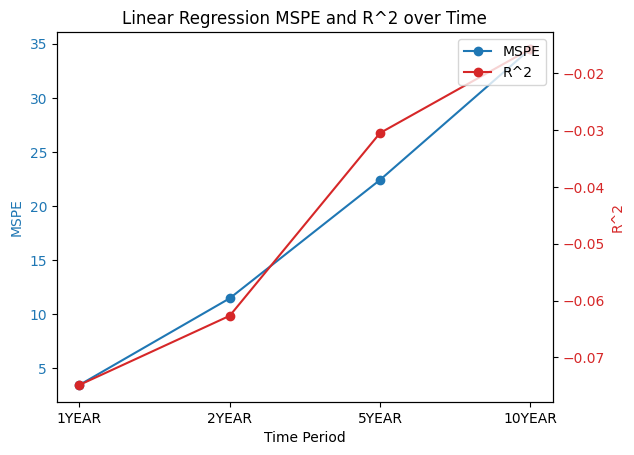

In [31]:
x_labels = ['1YEAR', '2YEAR', '5YEAR', '10YEAR']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_lr, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_lr, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Linear Regression MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

### Penalized linear regressions (Ridge, Lasso, Elastic Net)



In [32]:
mspe_ridge = []
r2_ridge = []

In [33]:
model_ridge = Ridge()
model_lasso = Lasso()

#### 1 YEAR

In [34]:
predict_ridge_1year = predict(data, model_ridge, '1YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_ridge_1year = r2_oos(np.array(data['1YEAR']), np.array(predict_ridge_1year[forecast_start:]))

print('R2:', r2_oos_ridge_1year)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_ridge_1year))
print('MSPE:', mspe)
mspe_ridge.append(mspe)
r2_ridge.append(*r2_oos_ridge_1year)

R2: [-0.25170744]
MSPE: 3.467633669500269


#### 2 YEAR

In [35]:
predict_ridge_2year = predict(data, model_ridge, '2YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_ridge_2year = r2_oos(np.array(data['2YEAR']), np.array(predict_ridge_2year[forecast_start:]))

print('R2:', r2_oos_ridge_2year)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_ridge_2year))
print('MSPE:', mspe)
mspe_ridge.append(mspe)
r2_ridge.append(*r2_oos_ridge_2year)

R2: [-0.19467819]
MSPE: 11.470029717463907


#### 5 YEAR

In [36]:
predict_ridge_5year = predict(data, model_ridge, '5YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_ridge_5year = r2_oos(np.array(data['5YEAR']), np.array(predict_ridge_5year[forecast_start:]))

print('R2:', r2_oos_ridge_5year)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_ridge_5year))
print('MSPE:', mspe)
mspe_ridge.append(mspe)
r2_ridge.append(*r2_oos_ridge_5year)

R2: [-0.09791595]
MSPE: 22.410954415898598


#### 10 YEAR

In [37]:
predict_ridge_10year = predict(data, model_ridge, '10YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_ridge_10year = r2_oos(np.array(data['10YEAR']), np.array(predict_ridge_10year[forecast_start:]))

print('R2:', r2_oos_ridge_10year)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_ridge_10year))
print('MSPE:', mspe)
mspe_ridge.append(mspe)
r2_ridge.append(*r2_oos_ridge_10year)

R2: [-0.05425213]
MSPE: 34.511100968036885


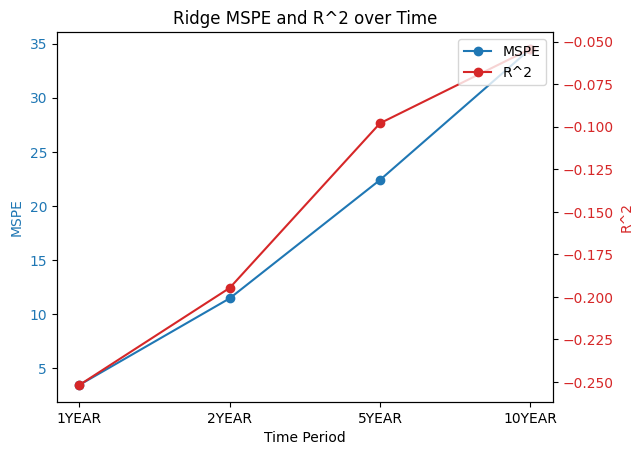

In [38]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_ridge, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_ridge, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Ridge MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

In [39]:
mspe_lasso = []
r2_lasso = []

#### 1 YEAR

In [40]:
predict_lasso_1year = predict(data, model_lasso, '1YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_lasso_1year = r2_oos(np.array(data['1YEAR']), np.array(predict_lasso_1year[forecast_start:]))

print('R2:', r2_oos_lasso_1year)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_lasso_1year))
print('MSPE:', mspe)
mspe_lasso.append(mspe)
r2_lasso.append(*r2_oos_lasso_1year)

R2: [-0.20305692]
MSPE: 3.3602000789893482


#### 2 YEAR

In [41]:
predict_lasso_2year = predict(data, model_lasso, '2YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_lasso_2year = r2_oos(np.array(data['2YEAR']), np.array(predict_lasso_2year[forecast_start:]))

print('R2:', r2_oos_lasso_2year)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_lasso_2year))
print('MSPE:', mspe)
mspe_lasso.append(mspe)
r2_lasso.append(*r2_oos_lasso_2year)

R2: [-0.10261758]
MSPE: 11.149714068587222


#### 5 YEAR

In [42]:
predict_lasso_5year = predict(data, model_lasso, '5YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_lasso_5year = r2_oos(np.array(data['5YEAR']), np.array(predict_lasso_5year[forecast_start:]))

print('R2:', r2_oos_lasso_5year)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_lasso_5year))
print('MSPE:', mspe)
mspe_lasso.append(mspe)
r2_lasso.append(*r2_oos_lasso_5year)

R2: [-0.00639147]
MSPE: 21.884400105898283


#### 10 YEAR

In [43]:
predict_lasso_10year = predict(data, model_lasso, '10YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_lasso_10year = r2_oos(np.array(data['10YEAR']), np.array(predict_lasso_10year[forecast_start:]))

print('R2:', r2_oos_lasso_10year)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_lasso_10year))
print('MSPE:', mspe)
mspe_lasso.append(mspe)
r2_lasso.append(*r2_oos_lasso_10year)

R2: [0.02442596]
MSPE: 33.93535518284424


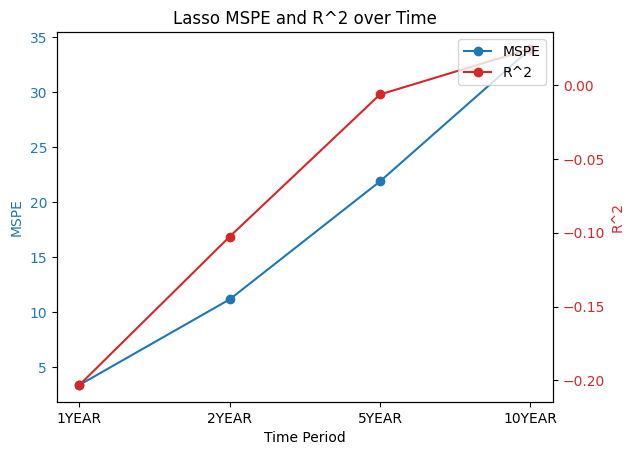

In [44]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_lasso, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_lasso, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Lasso MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

In [45]:
mspe_el_net = []
r2_el_net = []

In [46]:
model_el_net = ElasticNet()

#### 1 YEAR

In [47]:
predict_el_net_1year = predict(data, model_el_net, '1YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_el_net_1year = r2_oos(np.array(data['1YEAR']), np.array(predict_el_net_1year[forecast_start:]))

print('R2:', r2_oos_el_net_1year)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_el_net_1year))
print('MSPE:', mspe)
mspe_el_net.append(mspe)
r2_el_net.append(*r2_oos_el_net_1year)

R2: [-0.16256985]
MSPE: 3.3424405901940704


#### 2 YEAR

In [48]:
predict_el_net_2year = predict(data, model_el_net, '2YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_el_net_2year = r2_oos(np.array(data['2YEAR']), np.array(predict_el_net_2year[forecast_start:]))

print('R2:', r2_oos_el_net_2year)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_el_net_2year))
print('MSPE:', mspe)
mspe_el_net.append(mspe)
r2_el_net.append(*r2_oos_el_net_2year)

R2: [-0.11799947]
MSPE: 11.135323358161765


#### 5 YEAR

In [49]:
predict_el_net_5year = predict(data, model_el_net, '5YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_el_net_5year = r2_oos(np.array(data['5YEAR']), np.array(predict_el_net_5year[forecast_start:]))

print('R2:', r2_oos_el_net_5year)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_el_net_5year))
print('MSPE:', mspe)
mspe_el_net.append(mspe)
r2_el_net.append(*r2_oos_el_net_5year)

R2: [-0.04683098]
MSPE: 21.77875170701067


#### 10 YEAR

In [50]:
predict_el_net_10year = predict(data, model_el_net, '10YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_el_net_10year = r2_oos(np.array(data['10YEAR']), np.array(predict_el_net_10year[forecast_start:]))

print('R2:', r2_oos_el_net_10year)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_el_net_10year))
print('MSPE:', mspe)
mspe_el_net.append(mspe)
r2_el_net.append(*r2_oos_el_net_10year)

R2: [-0.00697634]
MSPE: 33.64501909831435


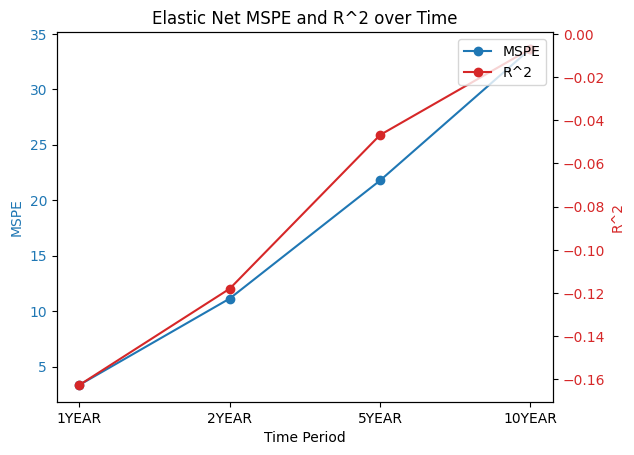

In [51]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_el_net, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_el_net, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elastic Net MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

#### Compare errors

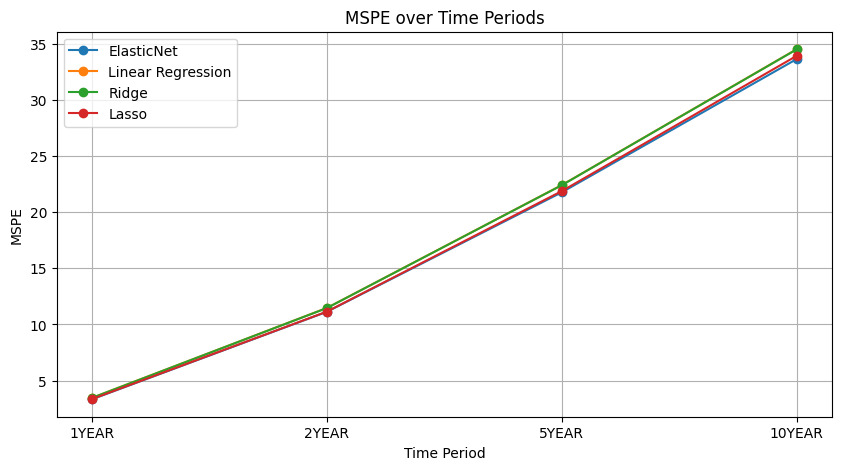

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(x_labels, mspe_el_net, marker='o', label='ElasticNet')
plt.plot(x_labels, mspe_lr, marker='o', label='Linear Regression')
plt.plot(x_labels, mspe_ridge, marker='o', label='Ridge')
plt.plot(x_labels, mspe_lasso, marker='o', label='Lasso')
plt.xlabel('Time Period')
plt.ylabel('MSPE')
plt.title('MSPE over Time Periods')
plt.legend()
plt.grid(True)
plt.show()

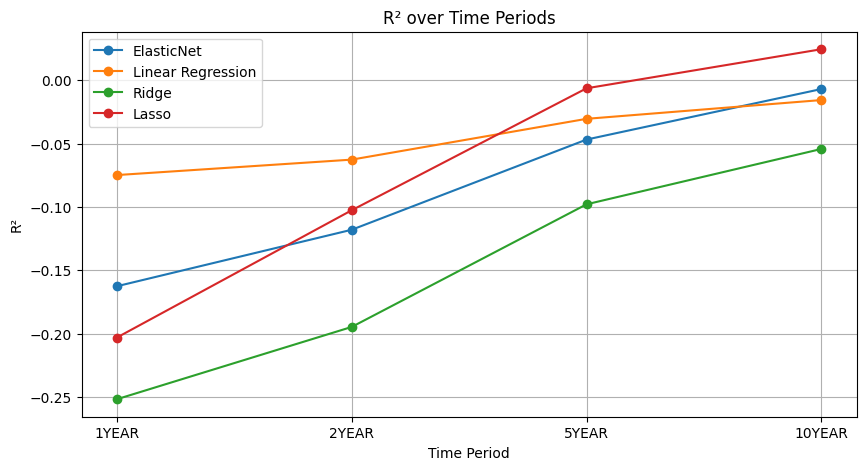

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(x_labels, r2_el_net, marker='o', label='ElasticNet')
plt.plot(x_labels, r2_lr, marker='o', label='Linear Regression')
plt.plot(x_labels, r2_ridge, marker='o', label='Ridge')
plt.plot(x_labels, r2_lasso, marker='o', label='Lasso')
plt.xlabel('Time Period')
plt.ylabel('R²')
plt.title('R² over Time Periods')
plt.legend()
plt.grid(True)
plt.show()

### Principal component analysis (PCA) (3, 5 and 10 components)

In [54]:
def pca(data, y, num_components):
  if num_components == 3:
    predictors = PREDICTORS[:3]
    X = data[predictors]
  else:
    X = data[PREDICTORS]
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  pca = PCA(n_components=num_components)
  X_pca = pca.fit_transform(X_scaled)
  model = LinearRegression()
  data_1 = data.copy()
  if num_components == 3:
    data_1[predictors] = X_pca
  else:
    data_1[PREDICTORS] = X_pca
  prediction = predict(data_1, model, y, forecast_start, None, 'expanding', 0.85)
  return prediction

In [55]:
def print_r_and_mpse(prediction, term):
  r2 = r2_oos(np.array(data[term]), np.array(prediction[forecast_start:]))
  print('R2:', r2)
  mspe = calculate_mspe(np.array(data[term]), np.array(prediction))
  print('MSPE:', mspe)
  print('-'*100)

#### 1YEAR PCA

In [56]:
prediction_1year_5 = pca(data, '1YEAR', 5)
print_r_and_mpse(prediction_1year_5, '1YEAR')

R2: [-0.25443637]
MSPE: 3.469362298632731
----------------------------------------------------------------------------------------------------


#### 2YEAR PCA

In [57]:
prediction_2year_5 = pca(data, '2YEAR', 5)
print_r_and_mpse(prediction_2year_5, '2YEAR')

R2: [-0.19711235]
MSPE: 11.476248641647187
----------------------------------------------------------------------------------------------------


#### 5YEAR PCA

In [58]:
prediction_5year_5 = pca(data, '5YEAR', 5)
print_r_and_mpse(prediction_5year_5, '5YEAR')

R2: [-0.09972228]
MSPE: 22.42066005703171
----------------------------------------------------------------------------------------------------


#### 10YEAR PCA

In [59]:
prediction_10year_5 = pca(data, '10YEAR', 5)
print_r_and_mpse(prediction_10year_5, '10YEAR')

R2: [-0.05585768]
MSPE: 34.52301030603012
----------------------------------------------------------------------------------------------------


### Random forests

In [60]:
mspe_rf = []
r2_rf = []

In [61]:
model_rf = RandomForestRegressor()

#### 1YEAR

In [62]:
predict_rf_1year = predict(data, model_rf, '1YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_rf_1year = r2_oos(np.array(data['1YEAR']), np.array(predict_rf_1year[forecast_start:]))

print('R2:', r2_oos_rf_1year)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_rf_1year))
print('MSPE:', mspe)
mspe_rf.append(mspe)
r2_rf.append(*r2_oos_rf_1year)

R2: [-0.05516354]
MSPE: 3.446328390028551


#### 2YEAR

In [63]:
predict_rf_2year = predict(data, model_rf, '2YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_rf_2year = r2_oos(np.array(data['2YEAR']), np.array(predict_rf_2year[forecast_start:]))

print('R2:', r2_oos_rf_2year)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_rf_2year))
print('MSPE:', mspe)
mspe_rf.append(mspe)
r2_rf.append(*r2_oos_rf_2year)

R2: [0.04373072]
MSPE: 11.417346773347623


#### 5YEAR

In [64]:
predict_rf = predict(data, model_rf, '5YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_rf = r2_oos(np.array(data['5YEAR']), np.array(predict_rf[forecast_start:]))

print('R2:', r2_oos_rf)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_rf))
print('MSPE:', mspe)
mspe_rf.append(mspe)
r2_rf.append(*r2_oos_rf)

R2: [0.11680654]
MSPE: 22.431666795199806


#### 10YEAR

In [65]:
predict_rf = predict(data, model_rf, '10YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_rf = r2_oos(np.array(data['10YEAR']), np.array(predict_rf[forecast_start:]))

print('R2:', r2_oos_rf)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_rf))
print('MSPE:', mspe)
mspe_rf.append(mspe)
r2_rf.append(*r2_oos_rf)

R2: [0.19163745]
MSPE: 34.9854959179279


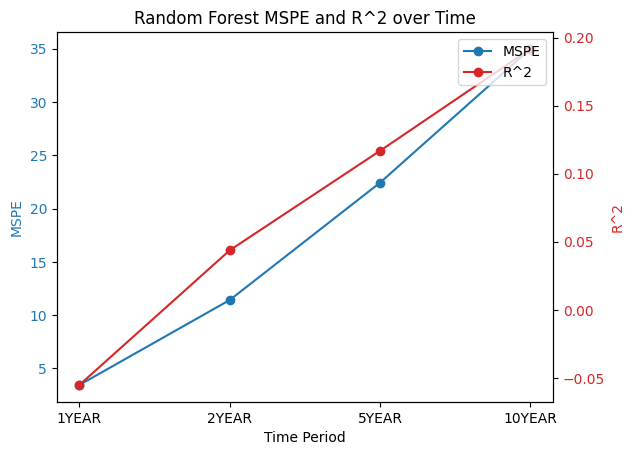

In [66]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_rf, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_rf, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Random Forest MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

### Boosted regression trees (XGBoost, AdaBoost)

In [67]:
mspe_xgb = []
r2_xgb = []

In [68]:
model_xgb = XGBRegressor()

#### 1YEAR

In [69]:
predict_xgb = predict(data, model_xgb, '1YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_xgb = r2_oos(np.array(data['1YEAR']), np.array(predict_xgb[forecast_start:]))

print('R2:', r2_oos_xgb)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_xgb))
print('MSPE:', mspe)
mspe_xgb.append(mspe)
r2_xgb.append(*r2_oos_xgb)

R2: [-0.03744245]
MSPE: 3.2341486354879767


#### 2YEAR

In [70]:
predict_xgb = predict(data, model_xgb, '2YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_xgb = r2_oos(np.array(data['2YEAR']), np.array(predict_xgb[forecast_start:]))

print('R2:', r2_oos_xgb)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_xgb))
print('MSPE:', mspe)
mspe_xgb.append(mspe)
r2_xgb.append(*r2_oos_xgb)

R2: [-0.00439874]
MSPE: 10.765224857562766


#### 5YEAR

In [71]:
predict_xgb = predict(data, model_xgb, '5YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_xgb = r2_oos(np.array(data['5YEAR']), np.array(predict_xgb[forecast_start:]))

print('R2:', r2_oos_xgb)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_xgb))
print('MSPE:', mspe)
mspe_xgb.append(mspe)
r2_xgb.append(*r2_oos_xgb)

R2: [0.07688531]
MSPE: 21.114036324273204


#### 10YEAR

In [72]:
predict_xgb = predict(data, model_xgb, '10YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_xgb = r2_oos(np.array(data['10YEAR']), np.array(predict_xgb[forecast_start:]))

print('R2:', r2_oos_xgb)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_xgb))
print('MSPE:', mspe)
mspe_xgb.append(mspe)
r2_xgb.append(*r2_oos_xgb)

R2: [0.08481881]
MSPE: 32.54715994480988


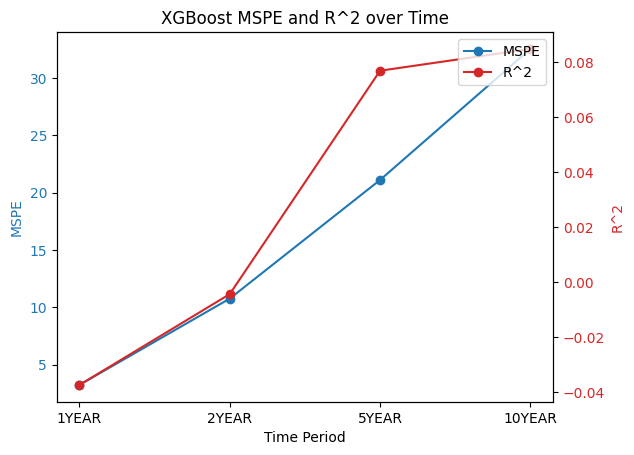

In [73]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_xgb, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_xgb, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('XGBoost MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

In [74]:
mspe_ada = []
r2_ada = []

In [75]:
model_ada = AdaBoostRegressor()

#### 1YEAR

In [76]:
predict_ada = predict(data, model_ada, '1YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_ada = r2_oos(np.array(data['1YEAR']), np.array(predict_ada[forecast_start:]))

print('R2:', r2_oos_ada)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_ada))
print('MSPE:', mspe)
mspe_ada.append(mspe)
r2_ada.append(*r2_oos_ada)

R2: [-0.16142285]
MSPE: 3.3267338672956033


#### 2YEAR

In [77]:
predict_ada = predict(data, model_ada, '2YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_ada = r2_oos(np.array(data['2YEAR']), np.array(predict_ada[forecast_start:]))

print('R2:', r2_oos_ada)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_ada))
print('MSPE:', mspe)
mspe_ada.append(mspe)
r2_ada.append(*r2_oos_ada)

R2: [-0.12804533]
MSPE: 10.95105036646606


#### 5YEAR

In [78]:
predict_ada = predict(data, model_ada, '5YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_ada = r2_oos(np.array(data['5YEAR']), np.array(predict_ada[forecast_start:]))

print('R2:', r2_oos_ada)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_ada))
print('MSPE:', mspe)
mspe_ada.append(mspe)
r2_ada.append(*r2_oos_ada)

R2: [-0.11659738]
MSPE: 21.55588362543414


#### 10YEAR

In [79]:
predict_ada = predict(data, model_ada, '10YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_ada = r2_oos(np.array(data['10YEAR']), np.array(predict_ada[forecast_start:]))

print('R2:', r2_oos_ada)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_ada))
print('MSPE:', mspe)
mspe_ada.append(mspe)
r2_ada.append(*r2_oos_ada)

R2: [-0.11072063]
MSPE: 33.29061740992097


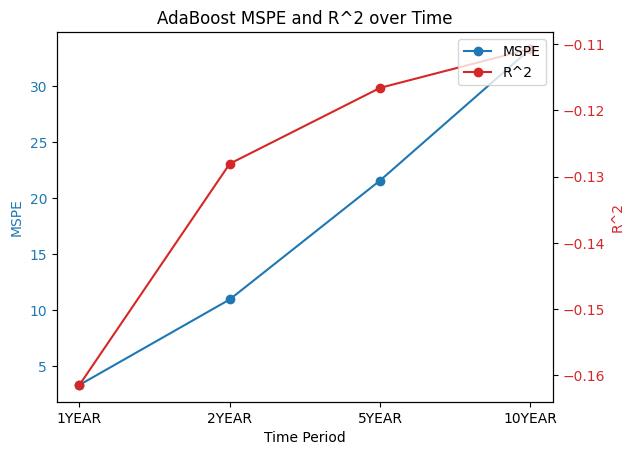

In [80]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_ada, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_ada, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('AdaBoost MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

### Extremely randomized regression trees

In [81]:
mspe_et = []
r2_et = []

In [82]:
model_et = ExtraTreesRegressor()

#### 1YEAR

In [83]:
predict_et = predict(data, model_et, '1YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_et = r2_oos(np.array(data['1YEAR']), np.array(predict_et[forecast_start:]))

print('R2:', r2_oos_et)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_et))
print('MSPE:', mspe)
mspe_et.append(mspe)
r2_et.append(*r2_oos_et)

R2: [-0.01634284]
MSPE: 3.42046519399472


#### 2YEAR

In [84]:
predict_et = predict(data, model_et, '2YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_et = r2_oos(np.array(data['2YEAR']), np.array(predict_et[forecast_start:]))

print('R2:', r2_oos_et)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_et))
print('MSPE:', mspe)
mspe_et.append(mspe)
r2_et.append(*r2_oos_et)

R2: [0.05450704]
MSPE: 11.38292698410307


#### 5YEAR

In [85]:
predict_et = predict(data, model_et, '5YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_et = r2_oos(np.array(data['5YEAR']), np.array(predict_et[forecast_start:]))

print('R2:', r2_oos_et)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_et))
print('MSPE:', mspe)
mspe_et.append(mspe)
r2_et.append(*r2_oos_et)

R2: [0.15026206]
MSPE: 22.572081631843076


#### 10YEAR

In [86]:
predict_et = predict(data, model_et, '10YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_et = r2_oos(np.array(data['10YEAR']), np.array(predict_et[forecast_start:]))

print('R2:', r2_oos_et)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_et))
print('MSPE:', mspe)
mspe_et.append(mspe)
r2_et.append(*r2_oos_et)

R2: [0.18714213]
MSPE: 35.08647628675119


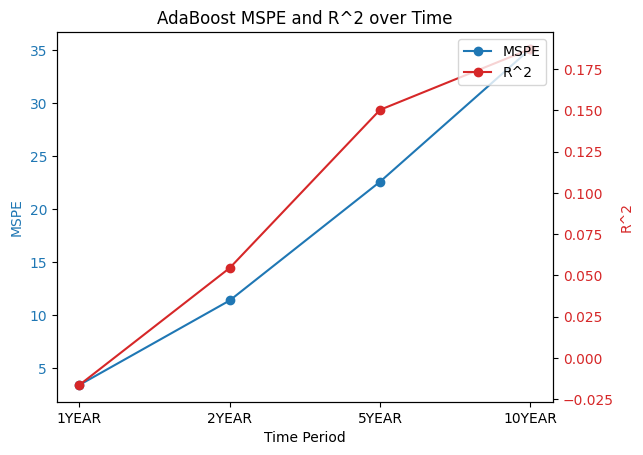

In [87]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_et, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_et, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('AdaBoost MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

#### Compare errors

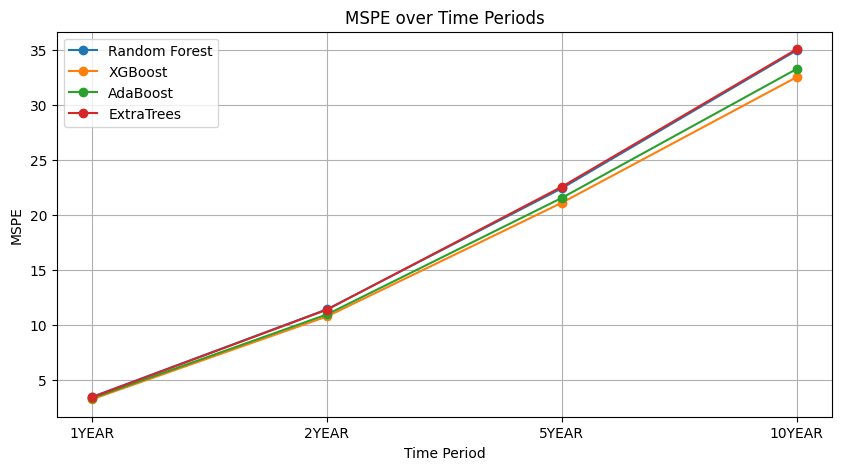

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(x_labels, mspe_rf, marker='o', label='Random Forest')
plt.plot(x_labels, mspe_xgb, marker='o', label='XGBoost')
plt.plot(x_labels, mspe_ada, marker='o', label='AdaBoost')
plt.plot(x_labels, mspe_et, marker='o', label='ExtraTrees')
plt.xlabel('Time Period')
plt.ylabel('MSPE')
plt.title('MSPE over Time Periods')
plt.legend()
plt.grid(True)
plt.show()

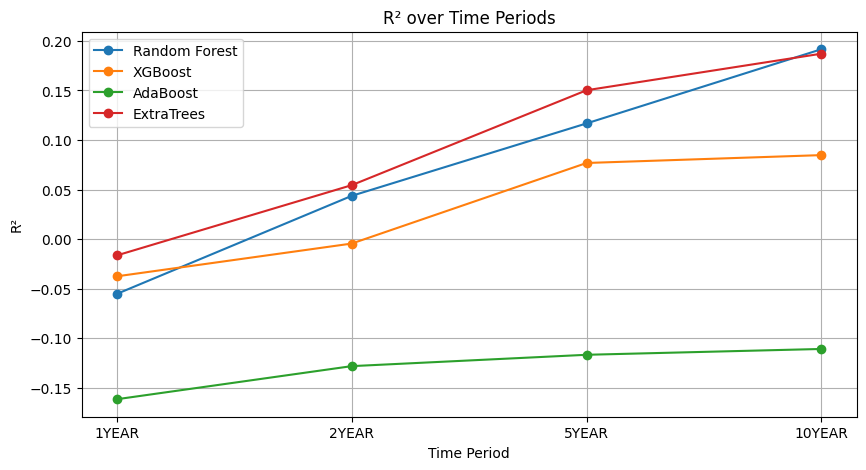

In [89]:
plt.figure(figsize=(10, 5))
plt.plot(x_labels, r2_rf, marker='o', label='Random Forest')
plt.plot(x_labels, r2_xgb, marker='o', label='XGBoost')
plt.plot(x_labels, r2_ada, marker='o', label='AdaBoost')
plt.plot(x_labels, r2_et, marker='o', label='ExtraTrees')
plt.xlabel('Time Period')
plt.ylabel('R²')
plt.title('R² over Time Periods')
plt.legend()
plt.grid(True)
plt.show()

### Neural networks: shallow vs. deep (1 layer with 16 nodes vs. 2 layers with 16-8 nodes)

In [90]:
split_ratio = 0.85
split_index = int(len(data) * split_ratio)

train_data = data.iloc[:split_index]
val_data = data.iloc[split_index:]

In [91]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

In [92]:
X_train = train_scaled[:, 4:]
y_train_1YEAR = train_scaled[:, 0]
y_train_2YEAR = train_scaled[:, 1]
y_train_5YEAR = train_scaled[:, 2]
y_train_10YEAR = train_scaled[:, 3]



X_val = val_scaled[:, 4:]
y_val_1YEAR = val_scaled[:, 0]
y_val_2YEAR = val_scaled[:, 1]
y_val_5YEAR = val_scaled[:, 2]
y_val_10YEAR = val_scaled[:, 3]

In [93]:
def build_model(layers):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=X_train.shape[1], activation='relu'))
    if len(layers) > 1:
        for units in layers[1:]:
            model.add(Dense(units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

In [94]:
def train_and_predict_in_blocks(X_train, y_train, X_val, y_val, layers, reestimate_interval):
    num_val_points = len(X_val)
    predictions = []
    history_list = []

    for start in range(0, num_val_points, reestimate_interval):
        end = min(start + reestimate_interval, num_val_points)

        # Build and train the model
        model = build_model(layers)
        history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val[start:end], y_val[start:end]), verbose=0)

        # Predict for the current block
        predictions.extend(model.predict(X_val[start:end]))

        # Expand training set
        X_train = np.vstack((X_train, X_val[start:end]))
        y_train = np.hstack((y_train, y_val[start:end]))
        history_list.append(history)

    return np.array(predictions), history_list

In [95]:
reestimate_interval = 30


In [96]:
# Shallow Network (1 layer with 16 nodes)
shallow_layers = [16]
shallow_predictions_1YEAR, shallow_history_1YEAR = train_and_predict_in_blocks(X_train, y_train_1YEAR, X_val, y_val_1YEAR, shallow_layers, reestimate_interval)
shallow_predictions_2YEAR, shallow_history_2YEAR = train_and_predict_in_blocks(X_train, y_train_2YEAR, X_val, y_val_2YEAR, shallow_layers, reestimate_interval)
shallow_predictions_5YEAR, shallow_history_5YEAR = train_and_predict_in_blocks(X_train, y_train_5YEAR, X_val, y_val_5YEAR, shallow_layers, reestimate_interval)
shallow_predictions_10YEAR, shallow_history_10YEAR = train_and_predict_in_blocks(X_train, y_train_10YEAR, X_val, y_val_10YEAR, shallow_layers, reestimate_interval)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [97]:
# Deep Network (2 layers with 16-8 nodes)
deep_layers = [16, 8]
deep_predictions_1YEAR, deep_history_1YEAR = train_and_predict_in_blocks(X_train, y_train_1YEAR, X_val, y_val_1YEAR, deep_layers, reestimate_interval)
deep_predictions_2YEAR, deep_history_2YEAR = train_and_predict_in_blocks(X_train, y_train_2YEAR, X_val, y_val_2YEAR, deep_layers, reestimate_interval)
deep_predictions_5YEAR, deep_history_5YEAR = train_and_predict_in_blocks(X_train, y_train_5YEAR, X_val, y_val_5YEAR, deep_layers, reestimate_interval)
deep_predictions_10YEAR, deep_history_10YEAR = train_and_predict_in_blocks(X_train, y_train_10YEAR, X_val, y_val_10YEAR, deep_layers, reestimate_interval)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [98]:
# Function to plot validation loss
def plot_validation_loss(history_list, title):
    val_loss = [hist.history['val_loss'][-1] for hist in history_list]
    plt.figure(figsize=(10, 6))
    plt.plot(val_loss, marker='o', label = 'validation loss by window')
    plt.title(title)
    plt.xlabel('Block Number')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [99]:
print("Shallow Network - 1YEAR MSPE:", calculate_mspe(y_val_1YEAR, shallow_predictions_1YEAR))
print("Shallow Network - 2YEAR MSPE:", calculate_mspe(y_val_2YEAR, shallow_predictions_2YEAR))
print("Shallow Network - 5YEAR MSPE:", calculate_mspe(y_val_5YEAR, shallow_predictions_5YEAR))
print("Shallow Network - 10YEAR MSPE:", calculate_mspe(y_val_10YEAR, shallow_predictions_10YEAR))

print("Deep Network - 1YEAR MSPE:", calculate_mspe(y_val_1YEAR, deep_predictions_1YEAR))
print("Deep Network - 2YEAR MSPE:", calculate_mspe(y_val_2YEAR, deep_predictions_2YEAR))
print("Deep Network - 5YEAR MSPE:", calculate_mspe(y_val_5YEAR, deep_predictions_5YEAR))
print("Deep Network - 10YEAR MSPE:", calculate_mspe(y_val_10YEAR, deep_predictions_10YEAR))

Shallow Network - 1YEAR MSPE: 0.10403570293304108
Shallow Network - 2YEAR MSPE: 0.11610639357260849
Shallow Network - 5YEAR MSPE: 0.2098341889041837
Shallow Network - 10YEAR MSPE: 0.25232345631277503
Deep Network - 1YEAR MSPE: 0.10570579728545332
Deep Network - 2YEAR MSPE: 0.15262387515771972
Deep Network - 5YEAR MSPE: 0.20184844338546215
Deep Network - 10YEAR MSPE: 0.2595863429478184


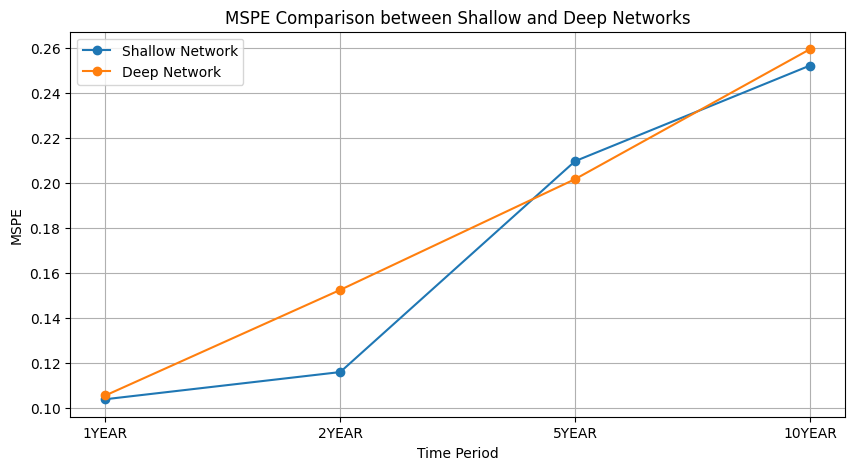

In [100]:
mspe_shallow = [
    calculate_mspe(y_val_1YEAR, shallow_predictions_1YEAR),
    calculate_mspe(y_val_2YEAR, shallow_predictions_2YEAR),
    calculate_mspe(y_val_5YEAR, shallow_predictions_5YEAR),
    calculate_mspe(y_val_10YEAR, shallow_predictions_10YEAR)
]

mspe_deep = [
    calculate_mspe(y_val_1YEAR, deep_predictions_1YEAR),
    calculate_mspe(y_val_2YEAR, deep_predictions_2YEAR),
    calculate_mspe(y_val_5YEAR, deep_predictions_5YEAR),
    calculate_mspe(y_val_10YEAR, deep_predictions_10YEAR)
]

plt.figure(figsize=(10, 5))
plt.plot(x_labels, mspe_shallow, marker='o', label='Shallow Network')
plt.plot(x_labels, mspe_deep, marker='o', label='Deep Network')
plt.xlabel('Time Period')
plt.ylabel('MSPE')
plt.title('MSPE Comparison between Shallow and Deep Networks')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
def r2_oos_updated(my_data, predict_model):
    sum1 = 0
    sum2 = 0
    window = len(my_data) - len(predict_model)

    for index in range(len(predict_model)):
        if index == 0:
            continue
        sum1 += np.square(my_data[index + window] - predict_model[index])
        sum2 += np.square(my_data[index + window] - np.mean(my_data[:index + window]))

    summary = 1 - sum1 / sum2
    return summary


In [102]:
print("Shallow Network - 1YEAR R² OOS:", r2_oos_updated(y_val_1YEAR, shallow_predictions_1YEAR))
print("Shallow Network - 2YEAR R² OOS:", r2_oos_updated(y_val_2YEAR, shallow_predictions_2YEAR))
print("Shallow Network - 5YEAR R² OOS:", r2_oos_updated(y_val_5YEAR, shallow_predictions_5YEAR))
print("Shallow Network - 10YEAR R² OOS:", r2_oos_updated(y_val_10YEAR, shallow_predictions_10YEAR))

print("Deep Network - 1YEAR R² OOS:", r2_oos_updated(y_val_1YEAR, deep_predictions_1YEAR))
print("Deep Network - 2YEAR R² OOS:", r2_oos_updated(y_val_2YEAR, deep_predictions_2YEAR))
print("Deep Network - 5YEAR R² OOS:", r2_oos_updated(y_val_5YEAR, deep_predictions_5YEAR))
print("Deep Network - 10YEAR R² OOS:", r2_oos_updated(y_val_10YEAR, deep_predictions_10YEAR))

Shallow Network - 1YEAR R² OOS: [-0.3181373]
Shallow Network - 2YEAR R² OOS: [-0.17101824]
Shallow Network - 5YEAR R² OOS: [-0.03215826]
Shallow Network - 10YEAR R² OOS: [-0.12950778]
Deep Network - 1YEAR R² OOS: [-0.58737457]
Deep Network - 2YEAR R² OOS: [-0.7462268]
Deep Network - 5YEAR R² OOS: [-0.34091341]
Deep Network - 10YEAR R² OOS: [-0.21611273]


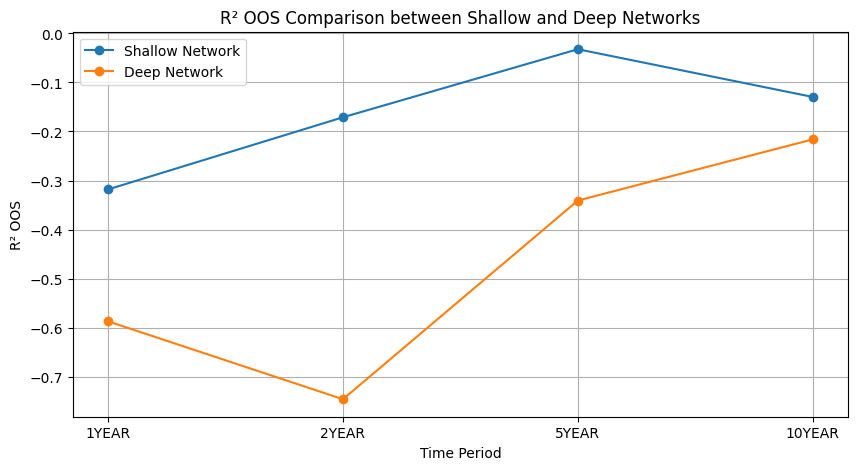

In [103]:
r2_shallow = [
    r2_oos_updated(y_val_1YEAR, shallow_predictions_1YEAR),
    r2_oos_updated(y_val_2YEAR, shallow_predictions_2YEAR),
    r2_oos_updated(y_val_5YEAR, shallow_predictions_5YEAR),
    r2_oos_updated(y_val_10YEAR, shallow_predictions_10YEAR)
]

r2_deep = [
    r2_oos_updated(y_val_1YEAR, deep_predictions_1YEAR),
    r2_oos_updated(y_val_2YEAR, deep_predictions_2YEAR),
    r2_oos_updated(y_val_5YEAR, deep_predictions_5YEAR),
    r2_oos_updated(y_val_10YEAR, deep_predictions_10YEAR)
]

plt.figure(figsize=(10, 5))
plt.plot(x_labels, r2_shallow, marker='o', label='Shallow Network')
plt.plot(x_labels, r2_deep, marker='o', label='Deep Network')
plt.xlabel('Time Period')
plt.ylabel('R² OOS')
plt.title('R² OOS Comparison between Shallow and Deep Networks')
plt.legend()
plt.grid(True)
plt.show()